In [ ]:
!python3 -m pip install pyinterval numpy

In [1]:
import numpy as np
from numpy.linalg import solve
from interval import interval

In [20]:
def solve2(a, b):
    det = a[0][0] * a[1][1] - a[0][1] * a[1][0]
    det1 = b[0] * a[1][1] - a[0][1] * b[1]
    det2 = a[0][0] * b[1] - b[0] * a[1][0]
    return np.array([det1 / det, det2 / det])

In [17]:
a = np.array([
    [3.0, 1.0],
    [2.0, 7.0]
])
b = np.array([6.0, 9.0])

In [18]:
assert(np.allclose(solve(a, b), solve2(a, b)))
solve2(a, b)

array([1.73684211, 0.78947368])

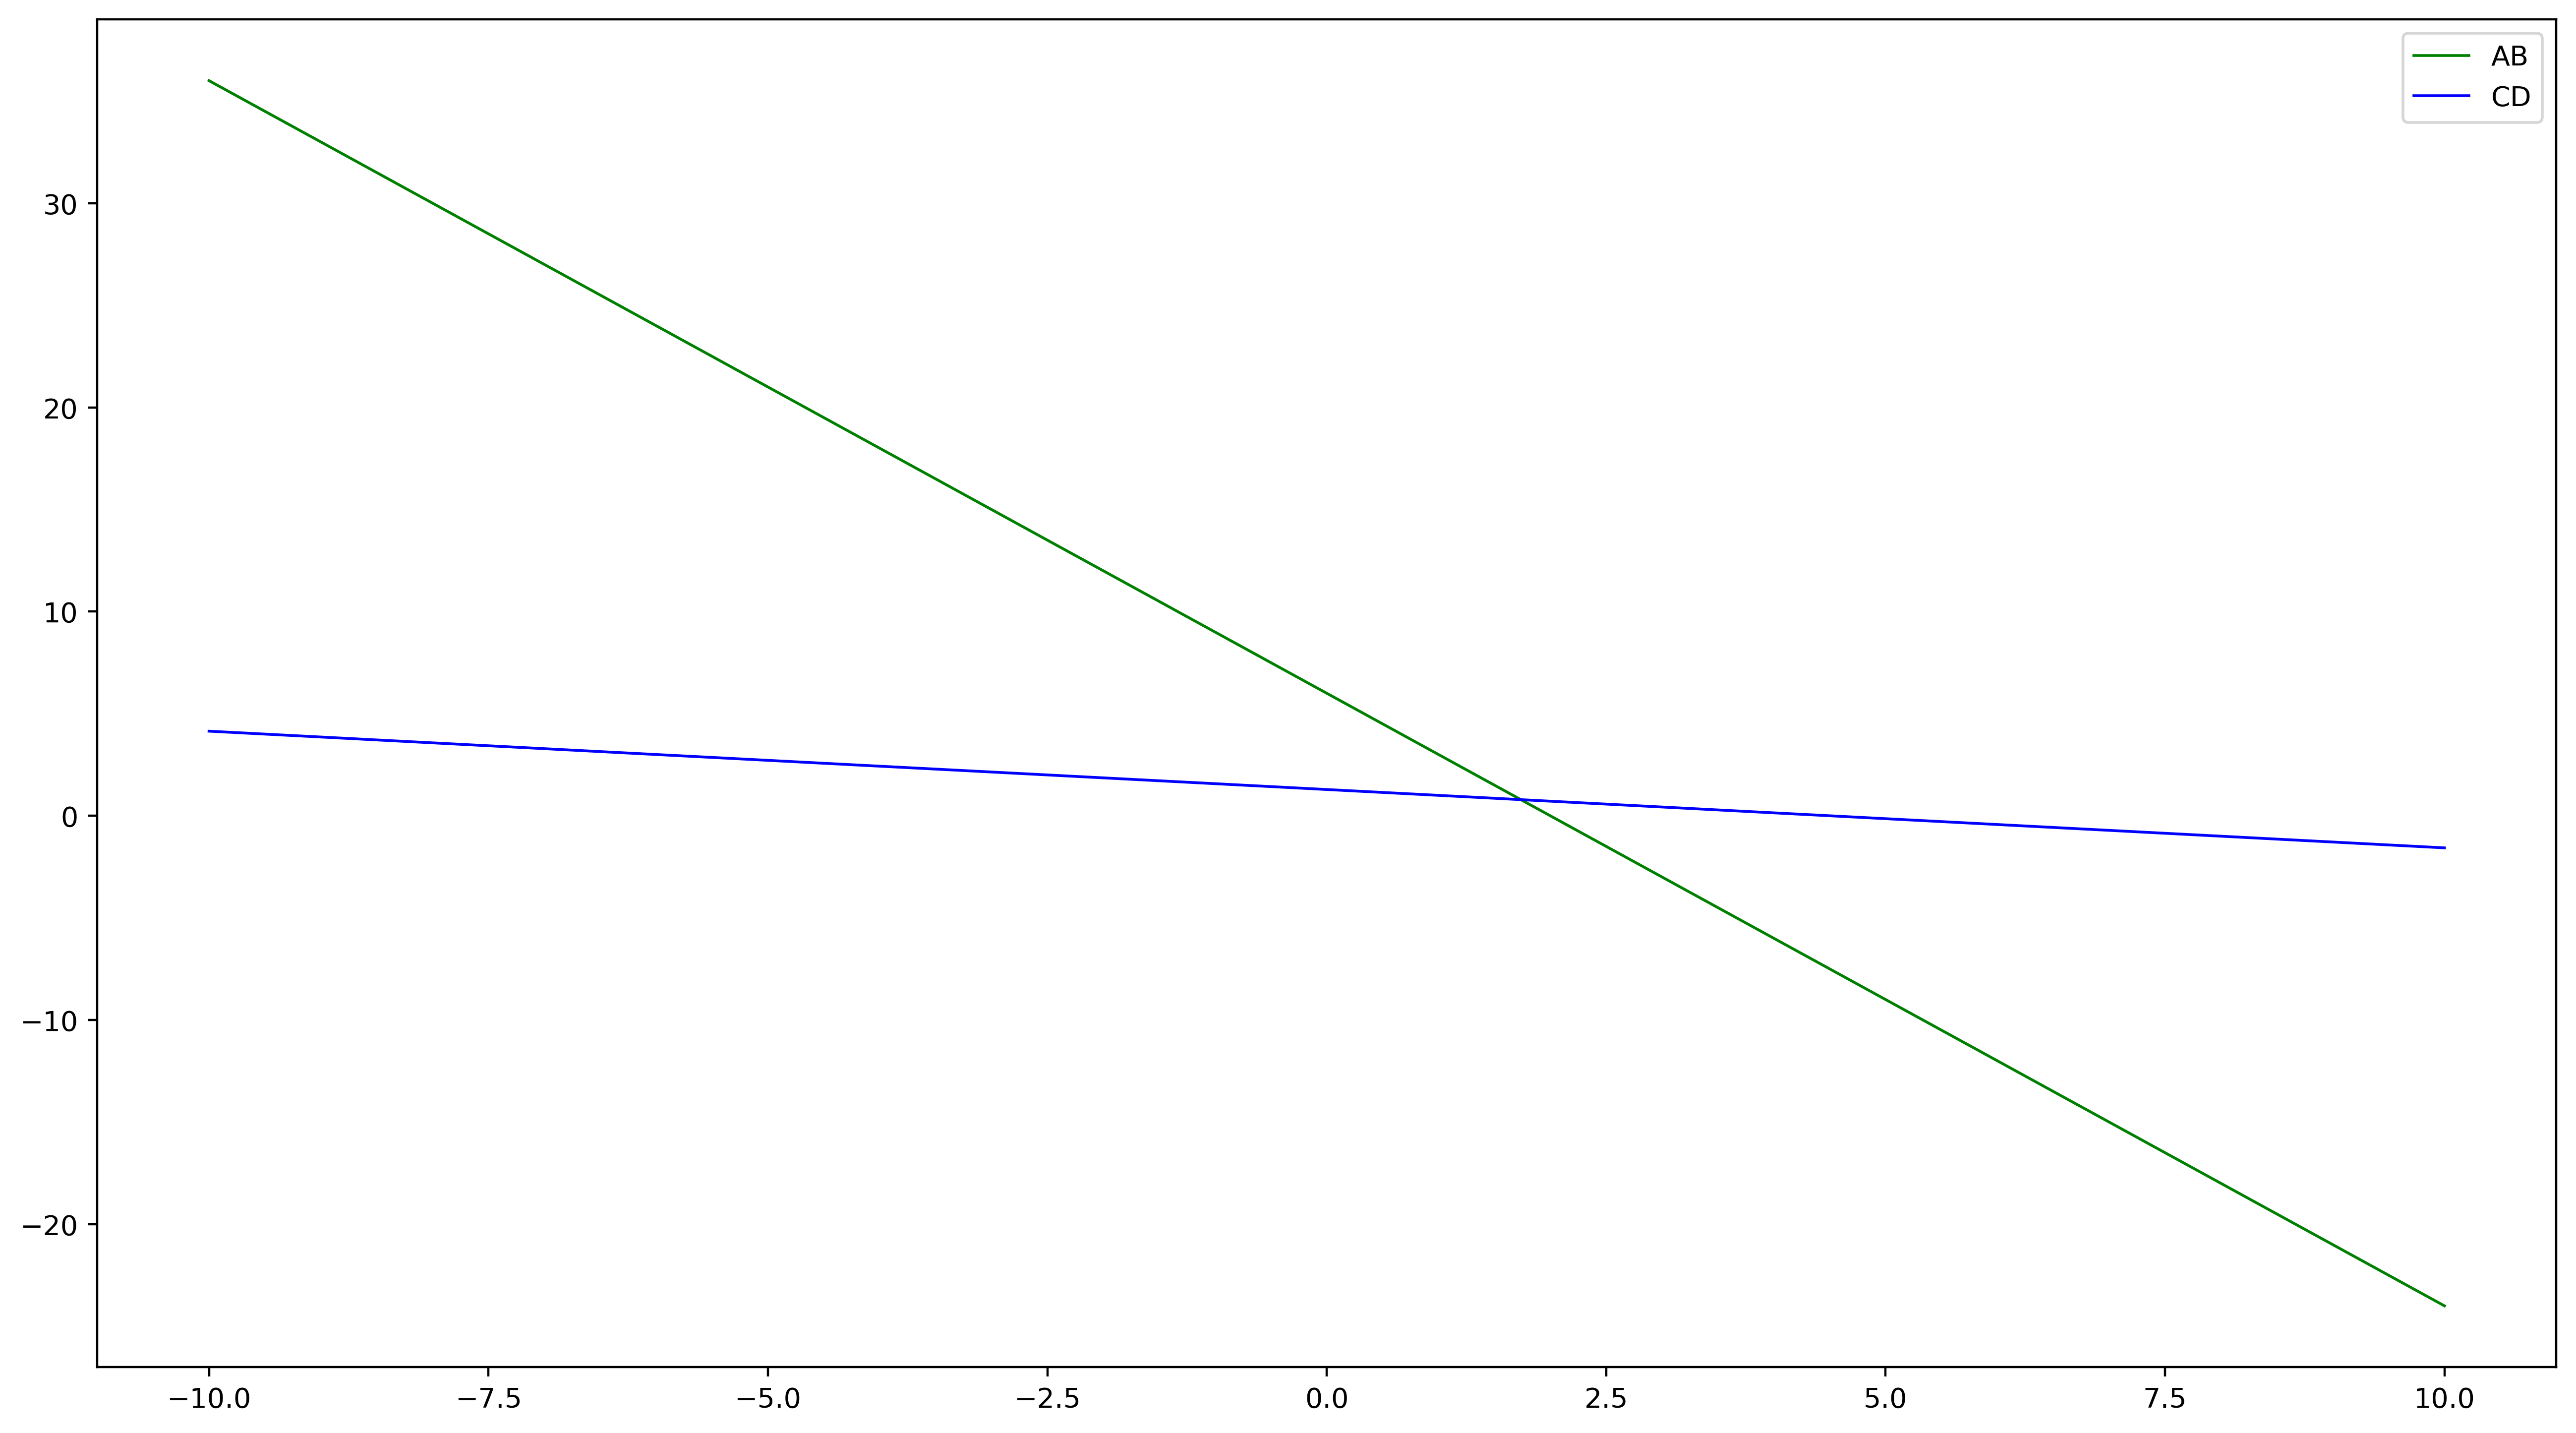

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 9), dpi=400)
subplot = fig.add_subplot(111, facecolor='#FFFFFF')
subplot.plot(x, AB, color='green', lw=1, label='AB')
subplot.plot(x, CD, color='blue', lw=1, label='CD')
plt.legend()
plt.show()

In [14]:
epsilon = 0.1
a_interval = np.array([
    [interval(a[0, 0], a[0, 0] + epsilon), interval(a[0, 1], a[0, 1] + epsilon)],
    [interval(a[1, 0], a[1, 0] + epsilon), interval(a[1, 1], a[1, 1] + epsilon)],
])
b_interval = np.array([interval(b[0], b[0] + epsilon), interval(b[1], b[1] + epsilon)])

solve2(a_interval, b_interval)

array([[[1.73684211, 1.73684211],
        [1.69035533, 1.69035533]],

       [[0.78947368, 0.78947368],
        [0.78172589, 0.78172589]]])

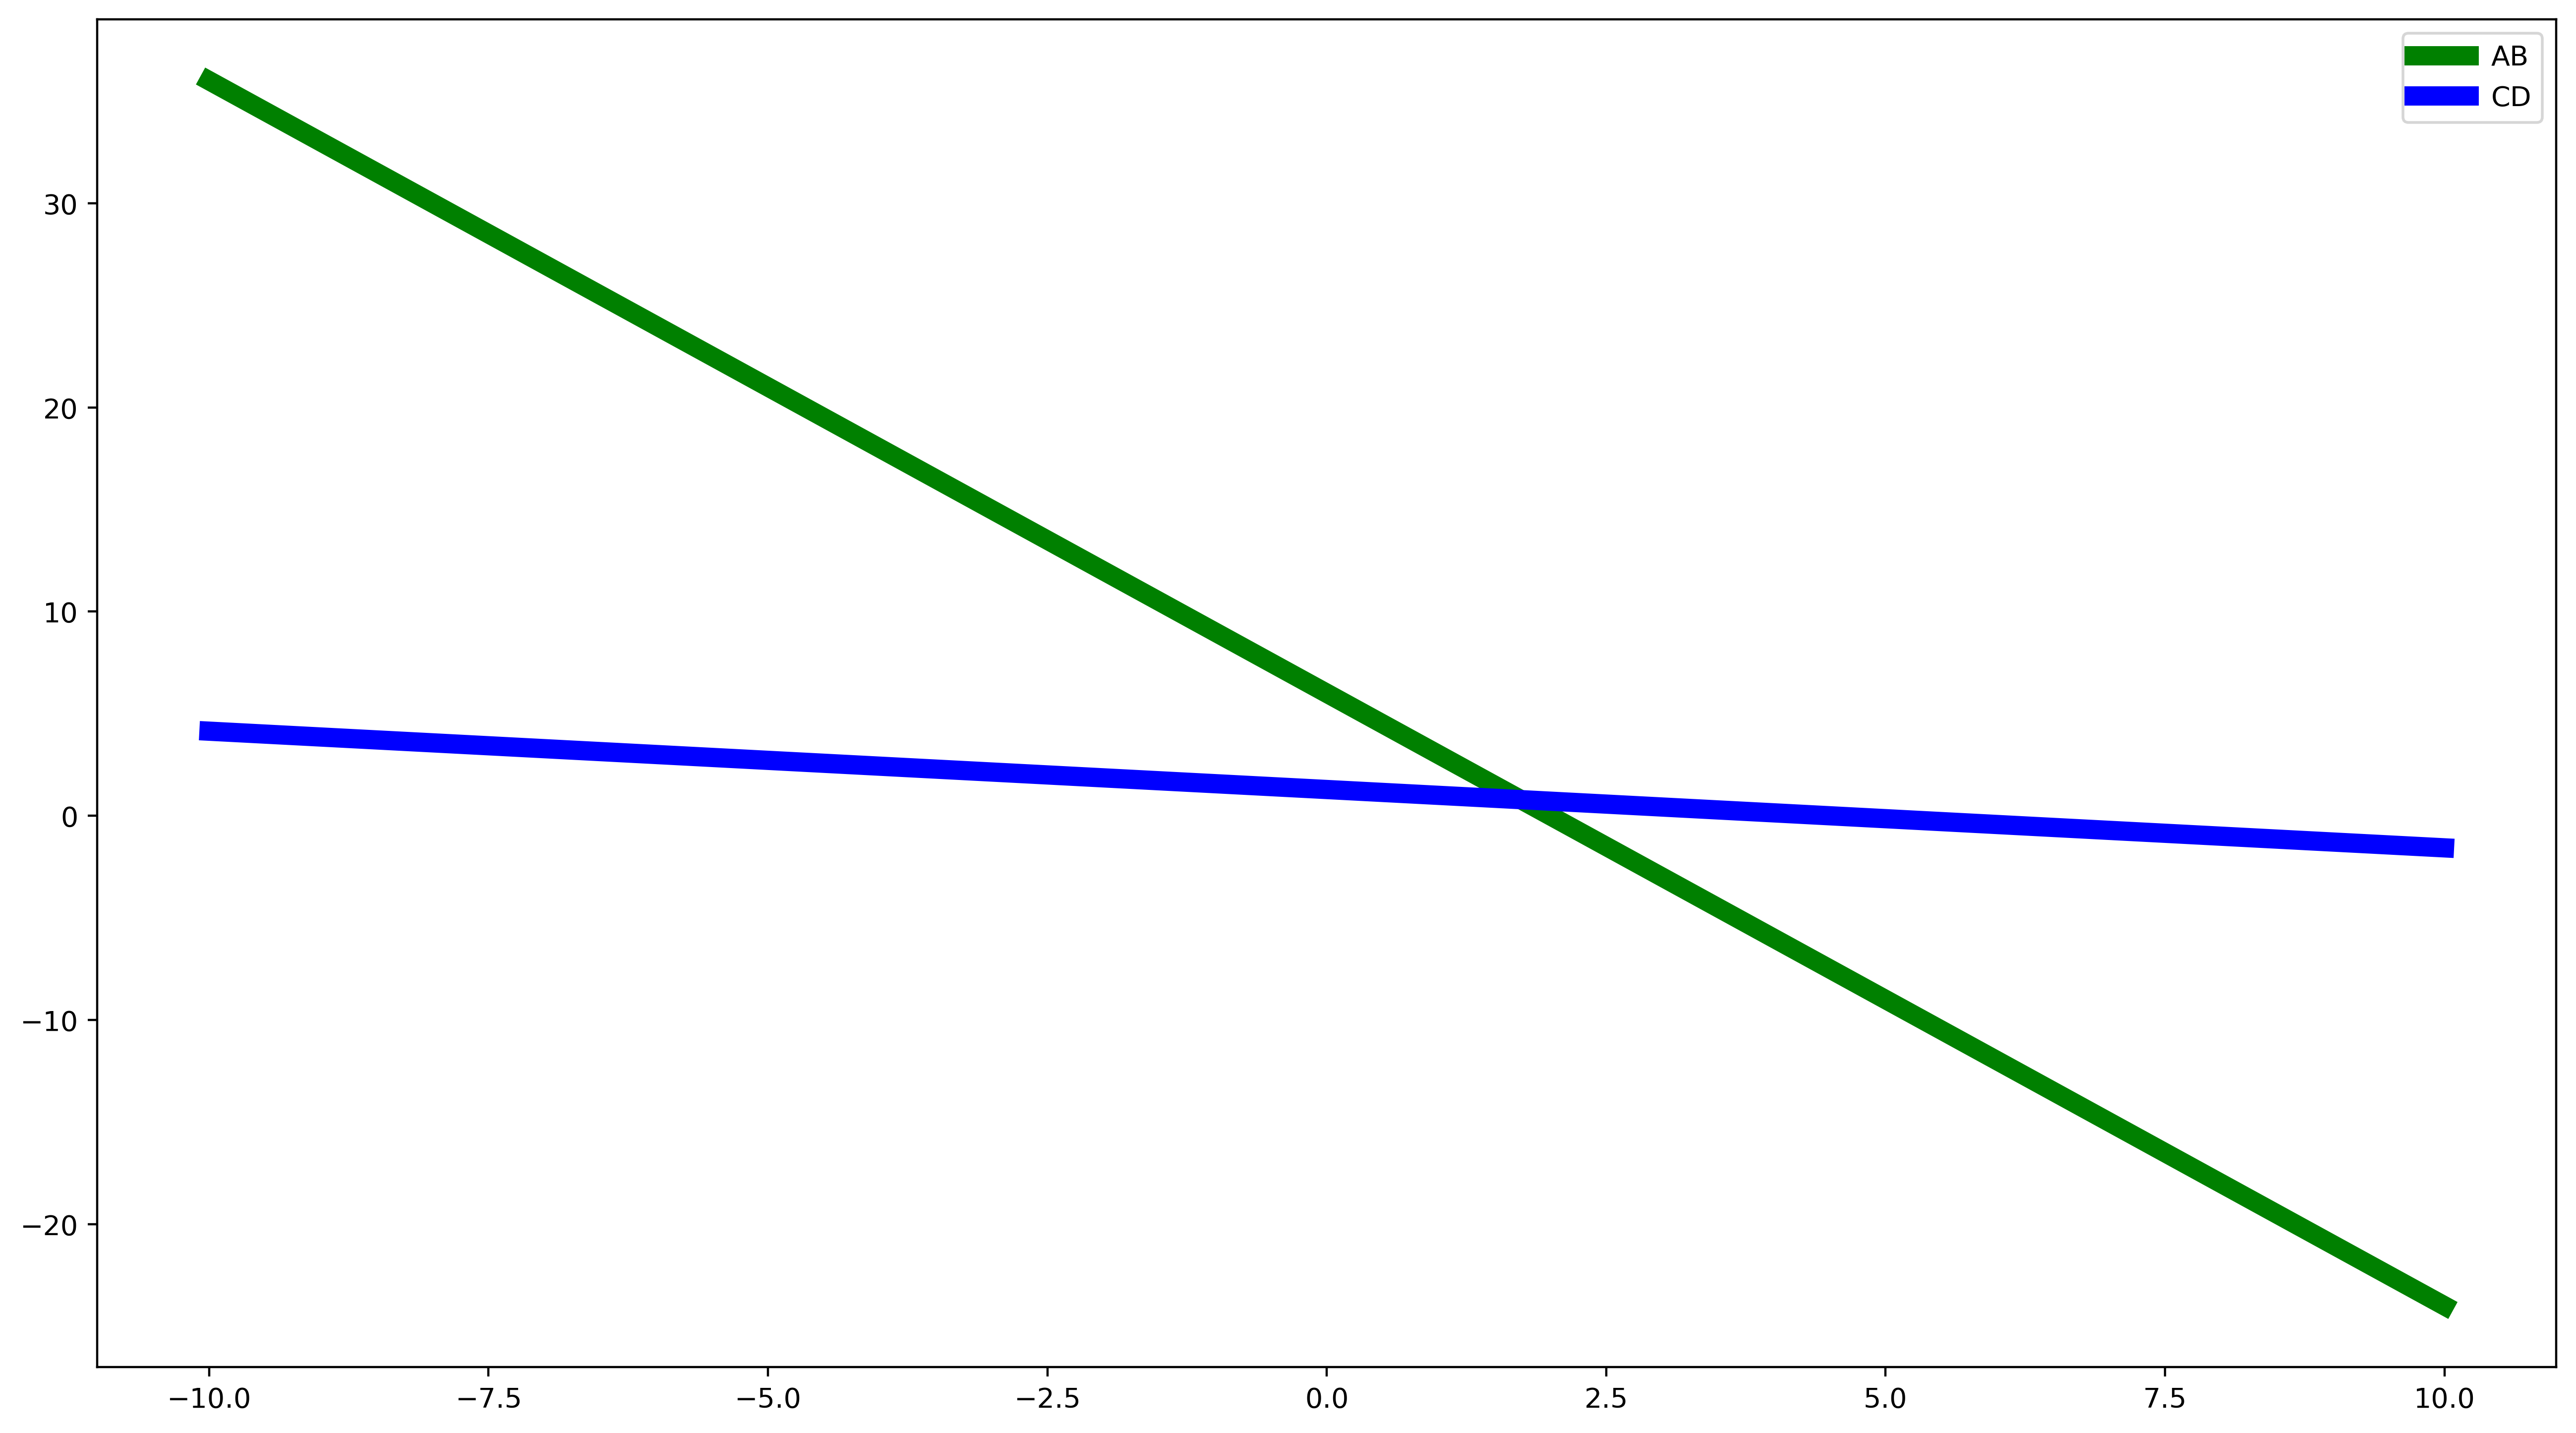

In [15]:
# u = np.array([-2, 6])
# v = np.array([4.5, 9.0 / 7.0])
x = np.linspace(-10, 10, 2**10 + 1)
AB = (b[0] - x * a[0, 0]) / a[0, 1]
CD = (b[1] - x * a[1, 0]) / a[1, 1]
fig = plt.figure(figsize=(16, 9), dpi=400)
subplot = fig.add_subplot(111, facecolor='#FFFFFF')
subplot.plot(x, AB, color='green', lw=7, label='AB')
subplot.plot(x, CD, color='blue', lw=7, label='CD')
plt.legend()
plt.show()